In [9]:
import numpy as np
import pandas as pd
import statistics

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score,log_loss,accuracy_score, roc_curve, confusion_matrix

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sys
project_path = '/scratch/cs/csb/projects/phenotype_classification'
sys.path.insert(0, project_path)

from src.utils.data import data_load
from src.models.MAP_estimator import MAP_estimator

In [10]:
#Load statistics of TCRs of training set
train = data_load('CMV','MAP_estimator/train.csv')

In [11]:
train.head()
train.tail()

,sample_name,unique_TCRs,phenotype_associated_TCRs,phenotype_status
0,HIP09097,123638,2,0
1,HIP05561,153097,0,0
2,HIP13856,277546,12,1
3,HIP05398,218577,1,0
4,HIP13975,286379,16,1


,sample_name,unique_TCRs,phenotype_associated_TCRs,phenotype_status
636,HIP13741,304946,3,0
637,HIP02024,277753,21,1
638,HIP01393,256285,3,0
639,HIP03484,119284,1,0
640,HIP10480,269476,13,1


unique_TCRs                  193665.992200
phenotype_associated_TCRs         6.926677
phenotype_status                  0.450858
dtype: float64

In [12]:
print('mean of the dataset')
train.mean()

print('Phenotype_status == 0')
train[train.phenotype_status==0].mean()

print('Phenotype_status == 1')
train[train.phenotype_status==1].mean()

mean of the dataset


unique_TCRs                  193665.992200
phenotype_associated_TCRs         6.926677
phenotype_status                  0.450858
dtype: float64

Phenotype_status == 0


unique_TCRs                  198229.846591
phenotype_associated_TCRs         1.877841
phenotype_status                  0.000000
dtype: float64

Phenotype_status == 1


unique_TCRs                  188107.249135
phenotype_associated_TCRs        13.076125
phenotype_status                  1.000000
dtype: float64

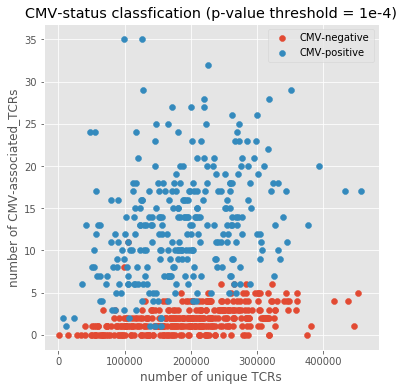

In [10]:
plt.figure(figsize=(6,6))
neg = train[train.phenotype_status==0]
pos = train[train.phenotype_status==1]
plt.scatter(neg.unique_TCRs,neg.phenotype_associated_TCRs,label='CMV-negative')
plt.scatter(pos.unique_TCRs,pos.phenotype_associated_TCRs,label='CMV-positive')
plt.xlabel('number of unique TCRs')
plt.ylabel('number of CMV-associated_TCRs')
plt.title('CMV-status classfication (p-value threshold = 1e-4)')
plt.legend()
plt.savefig('test.png')

## MOM initilization

In [13]:
train_c0 = train[train['phenotype_status']==0]
train_c1 = train[train['phenotype_status']==1]
n_c0 = train_c0.shape[0]
n_c1 = train_c1.shape[0]
print(n_c0, n_c1)

352 289


In [14]:
 # array of [n, k] of the negative class
c0_arr = train_c0[['unique_TCRs','phenotype_associated_TCRs']].values

# array of [n, k] of the positive class
c1_arr = train_c1[['unique_TCRs','phenotype_associated_TCRs']].values

In [20]:
i_c0_arr = np.delete(c0_arr, 0, 0)
i_c1_arr = np.delete(c1_arr, 0, 0)

In [25]:
init_params_c0 = estimate_beta_params_MOM_arr(i_c0_arr)
init_params_c1 = estimate_beta_params_MOM_arr(i_c1_arr)

In [26]:
init_params_c0
init_params_c1

[-0.4277134266046732, 0.12813321966300636]

[0.00010127537469950114, 1.0256056467203082e-08]

In [35]:
# lists n, k, k/n of the negative class
n_c0 = i_c0_arr[:,0]
k_c0 = i_c0_arr[:,1]

# lists n, k, k/n of the positive class
n_c1 =  i_c1_arr[:,0]
k_c1 =  i_c1_arr[:,1]

init_params_c0 = estimate_beta_params_MOM(n_c0,k_c0)
init_params_c1 = estimate_beta_params_MOM(n_c1,k_c1)

In [36]:
init_params_c0
init_params_c1

[33.673657572925215, 3559117.0023169178]

[7.188974687514556, 103209.93972822181]

In [24]:
def estimate_beta_params_MOM_arr(arr):
    """Estimating Beta binomial parameters by MOM
       Reference: https://stats.stackexchange.com/questions/320501/empirical-bayes-method-of-moments
    """
    K = np.sum(arr[1])
    N = np.sum(arr[0])
    N2 = np.sum(arr[0]**2)
    K_var = statistics.variance(arr[1])*len(arr[1])
    
    # (theta)^ = alpha/(alpha+beta)
    theta = K/N

    temp = (N2/N)-1
    temp2 = N*theta*(1-theta)
    temp3 = K_var-N*theta*(1-theta)

    alpha = theta*temp*(temp2/temp3)
    beta = (1-theta)*alpha/theta
    
    return [alpha, beta]

def jackknifing_MOM_init_arr(train):
    train_c0 = train[train['phenotype_status']==0]
    train_c1 = train[train['phenotype_status']==1]
    n_c0 = train_c0.shape[0]
    n_c1 = train_c1.shape[0]
    
    # array of [n, k] of the negative class
    c0_arr = train_c0[['unique_TCRs','phenotype_associated_TCRs']].values

    # array of [n, k] of the positive class
    c1_arr = train_c1[['unique_TCRs','phenotype_associated_TCRs']].values

    jackknifing_params_c0 = list()
    jackknifing_params_c1 = list()

    for i in range(n_c0):
        i_c0_arr = np.delete(n_c0, i, 0)
        init_params_c0 = estimate_beta_params_MOM_arr(i_c0_arr)
        jakknifing_params_c0.append(init_params_c0)
        
        
    for i in range(n_c1):
        i_c0_arr = np.delete(n_c1, i, 0)
        init_params_c1 = estimate_beta_params_MOM_arr(i_c1_arr)
        jakknifing_params_c1.append(init_params_c1)
        
    init_params_c0 = np.mean(jakknifing_params_c0, axis=0).tolist()
    init_params_c1 = np.mean(jackknifing_params_c1, axis=0).tolist()
    
    return [init_params_c0, init_params_c1]
    

In [34]:
def estimate_beta_params_MOM(n, k):
    """Estimating Beta binomial parameters by MOM
       Reference: https://stats.stackexchange.com/questions/320501/empirical-bayes-method-of-moments
    """
    K = np.sum(k)
    N = np.sum(n)
    N2 = np.sum(n**2)
    K_var = statistics.variance(k)*len(k)
    
    # (theta)^ = alpha/(alpha+beta)
    theta = K/N

    temp = (N2/N)-1
    temp2 = N*theta*(1-theta)
    temp3 = K_var-N*theta*(1-theta)

    alpha = theta*temp*(temp2/temp3)
    beta = (1-theta)*alpha/theta
    
    return [alpha, beta]
    

def MOM_init(train):
    train_c0 = train[train['phenotype_status']==0]
    train_c1 = train[train['phenotype_status']==1]

    # lists n, k, k/n of the negative class
    n_c0 = train_c0['unique_TCRs'].values
    k_c0 = train_c0['phenotype_associated_TCRs'].values

    # lists n, k, k/n of the positive class
    n_c1 = train_c1['unique_TCRs'].values
    k_c1 = train_c1['phenotype_associated_TCRs'].values
    
    init_params_c0 = estimate_beta_params_MOM(n_c0,k_c0)
    init_params_c1 = estimate_beta_params_MOM(n_c1,k_c1)
    
    return [init_params_c0, init_params_c1]

def jackknifing_MOM_init(train):
    train_c0 = train[train['phenotype_status']==0]
    train_c1 = train[train['phenotype_status']==1]
    n_c0 = train_c0.shape[0]
    n_c1 = train_c1.shape[0]
    
    # lists n, k, k/n of the negative class
    n_c0 = train_c0['unique_TCRs'].values
    k_c0 = train_c0['phenotype_associated_TCRs'].values

    # lists n, k, k/n of the positive class
    n_c1 = train_c1['unique_TCRs'].values
    k_c1 = train_c1['phenotype_associated_TCRs'].values

    alpha_c0_list = list()
    alpha_c1_list = list()
    beta_c0_list = list()
    beta_c1_list = list()

    for i in range(n_c0):
        i_n_c0 = np.delete(n_c0, i)
        i_k_c0 = np.delete(n_c0, i)
        init_params_c0 = estimate_beta_params_MOM(i_n_c0,i_k_c0)
        alpha_c0.append(init_params_c0[0])
        beta_c0.append(init_params_c0[1])
        
    for i in range(n_c1):
        init_params_c0 = estimate_beta_params_MOM(n_c0,k_c0)
        i_n_c0 = np.delete(n_c1, i)
        i_k_c0 = np.delete(n_c1, i)
        init_params_c0 = estimate_beta_params_MOM(i_n_c0,i_k_c0)
        alpha_c0.append(init_params_c0[0])
        beta_c0.append(init_params_c0[1])
    

In [4]:
threshold = 1e-4
y_true = []
y_proba = [] 
loo = LeaveOneOut()

def MAP_predict(train,test,prior_c0,prior_c1):
        '''
        Predicting testing data
        '''
        MAP = MAP_estimator(prior_c0,prior_c1) # construct a MAP_estimator instance
        MAP.fit(train,'unique_TCRs','phenotype_associated_TCRs','phenotype_status') # train the model using training set
        print('optimized priors:', 'class 0:', list(np.around(MAP.priors()[0],3)),
            ', class 1:', list(np.around(MAP.priors()[1],3))) # print the optimized priors

        y_pred = MAP.predict(test,'unique_TCRs','phenotype_associated_TCRs')[0] # predict the label
        y_proba = MAP.predict_proba_pos(test,'unique_TCRs','phenotype_associated_TCRs')[0] # compute the positive-class posterior probability

        return y_pred, y_proba


for train_index,test_index in loo.split(train):
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index]
    test_sample = test_cv['sample_name'].values[0]
#     MAP_data = pd.read_pickle(CMV_data_path + 'LOO_MAP_data/'+test_sample+'.pkl')
    MAP_data = data_load('CMV', 'LOO_MAP_data/'+test_sample+'.pkl')

    MAP_data['phenotype_associated_TCRs']= MAP_data[threshold]
    train_MAP = MAP_data[MAP_data.sample_name.isin(train_cv['sample_name'])]
    test_MAP = MAP_data[MAP_data.sample_name.isin(test_cv['sample_name'])]

    priors_init = MOM_init(train_MAP)
    print('priors initialization:','class 0:', list(np.around(np.array(priors_init[0]),3)),
        ', class 1:', list(np.around(np.array(priors_init[1]),3)))
    prior_c0 = priors_init[0]
    prior_c1 = priors_init[1]
    test_pred, test_proba = MAP_predict(train_MAP,test_MAP,prior_c0,prior_c1)

    print('test sample:',test_sample, ', unique_TCRs:',test_MAP['unique_TCRs'].tolist()[0],', associated_TCRs:',test_MAP['phenotype_associated_TCRs'].tolist()[0])           
    print('y_true:',test_MAP['phenotype_status'].tolist()[0],', y_pred:',test_pred,
        ', y_proba_pos: %.3f'%test_proba)
    print()
    y_true.append(test_MAP['phenotype_status'].tolist()[0])
    y_proba.append(test_proba)
print('loocv auroc: %.3f' % roc_auc_score(y_true,y_proba))
print('loocv log_loss: %.3f' % log_loss(y_true,y_proba))

# fpr_cv,tpr_cv,thresholds_cv = roc_curve(cv_y,cv_post_pos,pos_label=1)
# print('roc_auc_score:',roc_auc_score(cv_y,cv_post_pos))

priors initialization: class 0: [43.757, 4562510.568] , class 1: [7.318, 104471.4]
optimized priors: class 0: [43.786, 4562510.567] , class 1: [7.657, 104471.399]
test sample: HIP09097 , unique_TCRs: 123638 , associated_TCRs: 2
y_true: 0 , y_pred: 0 , y_proba_pos: 0.087

priors initialization: class 0: [46.786, 4861723.832] , class 1: [7.318, 104471.4]
optimized priors: class 0: [46.819, 4861723.829] , class 1: [7.657, 104471.399]
test sample: HIP05561 , unique_TCRs: 153097 , associated_TCRs: 0
y_true: 0 , y_pred: 0 , y_proba_pos: 0.003

priors initialization: class 0: [21.69, 2361050.843] , class 1: [7.459, 108705.545]
optimized priors: class 0: [21.743, 2361050.842] , class 1: [7.799, 108705.544]
test sample: HIP13856 , unique_TCRs: 277546 , associated_TCRs: 9
y_true: 1 , y_pred: 1 , y_proba_pos: 0.918

priors initialization: class 0: [45.25, 4704732.981] , class 1: [7.129, 101388.078]
optimized priors: class 0: [45.281, 4704732.98] , class 1: [7.467, 101388.077]
test sample: HIP0539

In [ ]:

MAP = MAP_estimator(priors_init[0],priors_init[1])

In [5]:
test = data_load('CMV','MAP_estimator/'+'test.csv')

In [10]:
priors_init = MOM_init(train_MAP)
MAP = MAP_estimator(priors_init[0],priors_init[1])
MAP.fit(train, 'unique_TCRs', 'phenotype_associated_TCRs', 'phenotype_status')

In [11]:
y_pred = MAP.predict(test,'unique_TCRs','phenotype_associated_TCRs') # predict the label
y_proba = MAP.predict_proba_pos(test,'unique_TCRs','phenotype_associated_TCRs') # compute the positive-class posterior probability


print('Accuracy: %.3f'%accuracy_score(test['phenotype_status'],y_pred))
print('AUROC: %.3f'%roc_auc_score(test['phenotype_status'],y_proba))
print('Confusion matrix:')
print(pd.DataFrame(confusion_matrix(test['phenotype_status'],y_pred),columns=['Predicted_negative','Predicted_positive'],
                        index=['Actual_negative','Actual_positive']))

Accuracy: 0.892
AUROC: 0.940
Confusion matrix:
                 Predicted_negative  Predicted_positive
Actual_negative                  62                   7
Actual_positive                   6                  45


## jackknifing sampling